In [1]:
# import of standard python libraries
import numpy as np
import corner
import matplotlib.pyplot as plt
import h5py
import lenstronomy


%matplotlib inline
%load_ext lab_black

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

For the first example of lensing data, no PSF was used to create the data.
Therefore, `psf_type` is set to `NONE`. For real data, there has to be a PSF
. We will work with PSFs in later examples.

In [2]:
with h5py.File("./DESIJ1554+0443/DESIJ1554+0443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("./DESIJ1554+0443/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


# For solving "TypeError: 'numpy.int64' object does not support item assignment" error
# kwargs_data["exposure_time"] = float(kwargs_data["exposure_time"])

kwargs_data

{'background_rms': 0.0137866616807371,
 'dec_at_xy_0': -4.839999999999995,
 'exposure_time': array([[526.58203, 420.42545, 478.3544 , ..., 533.4616 , 399.34912,
         517.8962 ],
        [424.4987 , 484.88034, 551.4943 , ..., 489.48572, 418.86212,
         522.29926],
        [384.8858 , 505.07867, 419.24973, ..., 487.39197, 435.3952 ,
         508.632  ],
        ...,
        [498.08844, 443.47632, 427.97556, ..., 498.2728 , 343.41418,
         507.6376 ],
        [427.0364 , 436.4274 , 502.66687, ..., 506.71988, 465.6584 ,
         510.76175],
        [410.01215, 504.86472, 437.02142, ..., 376.98816, 511.93005,
         502.43845]], dtype=float32),
 'image_data': array([[ 0.01204894,  0.00179044,  0.0021683 , ..., -0.01431787,
          0.01175164, -0.00076203],
        [ 0.00971342,  0.00726407,  0.00480296, ..., -0.00116851,
         -0.00183223, -0.01219291],
        [-0.00765296, -0.00050401,  0.00288014, ..., -0.02108379,
         -0.02647783, -0.01446793],
        ...,
     

/tmp/ipykernel_25106/3612032868.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


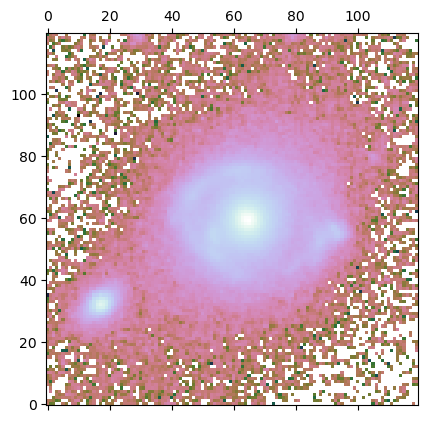

In [3]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")

In [157]:
# To make a mask using lenstronomy functions, here is an example code:

from lenstronomy.Util import mask_util
from lenstronomy.Util import util

from lenstronomy.Data.coord_transforms import Coordinates


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 5  # arcsecond
r2 = 2.5
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),
# )


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.5,
    lens_center_dec - 2.2,
    1,
    1,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.5,
    lens_center_dec + 1.7,
    0.5,
    0.5,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.7,
    lens_center_dec - 0.4,
    0.3,
    0.3,
    0,
)

mask1 = (1 - mask_outer_1) * (1 - mask_ext_1) * (1 - mask_ext_2) * (1 - mask_ext_3)
mask1[mask1 >= 1] = 1
mask1[mask1 < 0] = 0


# mask2 = (1 - mask_outer_2) * (1 - mask_ext_1)
# mask2[mask2 >= 1] = 1
# mask2[mask2 < 0] = 0

mask_img_1 = mask1.reshape(num_pix, num_pix)
# mask_img_2 = mask2.reshape(num_pix, num_pix)

## Applying mask

/tmp/ipykernel_25106/1266824895.py:4: RuntimeWarning: divide by zero encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)
/tmp/ipykernel_25106/1266824895.py:4: RuntimeWarning: invalid value encountered in log10
  image1 = np.log10(kwargs_data["image_data"] * mask_img_1)


Text(0.5, 1.0, 'Masked image')

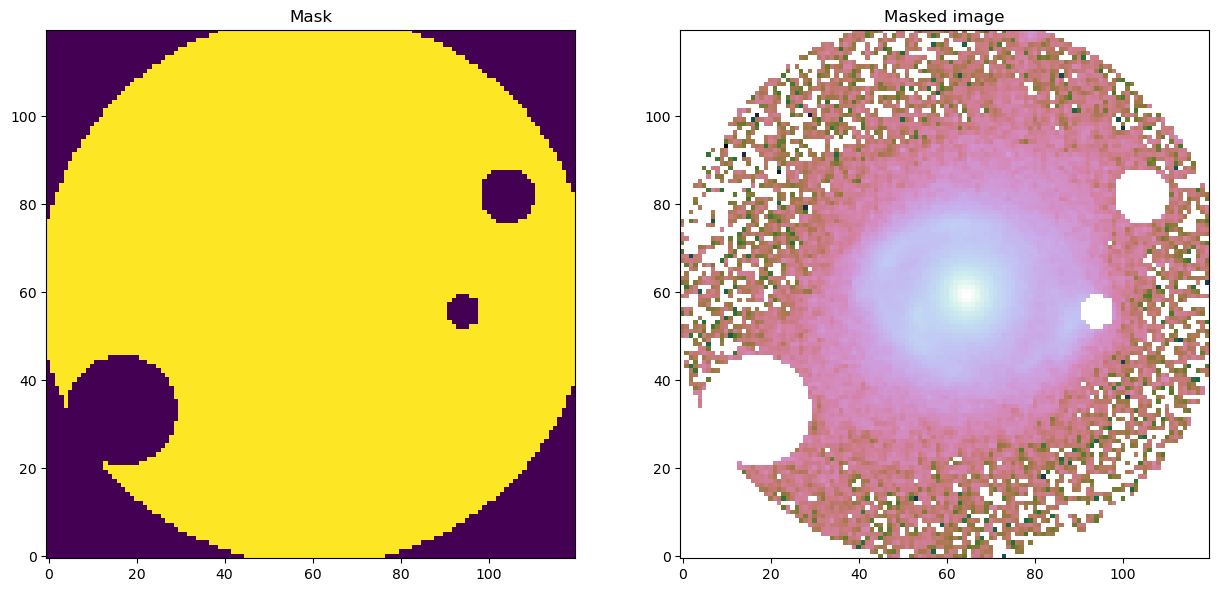

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image1 = np.log10(kwargs_data["image_data"] * mask_img_1)
# image2 = np.log10(kwargs_data["image_data"] * mask_img_2)


plt.sca(axs[0])
plt.imshow(mask_img_1, origin="lower")
plt.title("Mask")
# plt.colorbar()


# plt.sca(axs[0, 1])
# plt.imshow(mask_img_2, origin="lower")
# plt.title("Mask 2")
# plt.colorbar()


# plt.matshow(np.log10(image), origin="lower", cmap="cubehelix")


plt.sca(axs[1])
plt.imshow(image1, origin="lower", cmap="cubehelix")
plt.title("Masked image")


# plt.sca(axs[1, 1])
# plt.imshow(image2, origin="lower", cmap="cubehelix")
# plt.title("Image applying mask 2")

In [159]:
print("Mask dimension:", mask_img_1.shape, "\nMask type: ", type(mask_img_1))
# print("Mask2 dimension:", mask_img_2.shape, "\nMask2 type: ", type(mask_img_2))

Mask dimension: (120, 120) 
Mask type:  <class 'numpy.ndarray'>


## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [160]:
lens_model_list = ["EPL", "SHEAR"]


source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]  # beta, n_max, center_x, center_y


lens_light_model_list = ["SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [161]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


#'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.70368,
        "gamma": 1.57173,
        "e1": 0.01133,
        "e2": -0.07569,
        "center_x": -0.32511,
        "center_y": -0.09292,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

#'SHEAR'
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.12987, "gamma2": 0.03846})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# for 'SERSIC_ELLIPSE'
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.23144,
        "n_sersic": 1.0,
        "e1": -0.15631,
        "e2": -0.67131,
        "center_x": -0.27066,
        "center_y": 0.07217,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.01,
        "center_y": 0.01,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.7,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
    }
)
# for ‘SHAPELETS’
fixed_source.append({"n_max": 5})
kwargs_source_init.append(
    {"beta": 0.29894, "n_max": 5, "center_x": -0.27066, "center_y": 0.07217}
)
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.01, "center_y": 0.01})
kwargs_lower_source.append({"beta": 0, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.5, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_source_with_source,
}

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [162]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img_1]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [163]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
}

## Here the model fiting is done

In [164]:
###Define init_samples#####

# {'kwargs_lens': [{'theta_E': 0.4807542996180769,
#    'gamma': 1.2764227773853283,
#    'e1': -0.020313440803368932,
#    'e2': -0.03475866348738267,
#    'center_x': -0.3289112713465764,
#    'center_y': -0.0933495391132122},
#   {'gamma1': 0.0788017520487576,
#    'gamma2': -0.03141178493561385,
#    'ra_0': 0,
#    'dec_0': 0}],
#  'kwargs_source': [{'amp': 1,
#    'R_sersic': 0.8579196692822274,
#    'n_sersic': 1.0,
#    'e1': -0.2611644666914724,
#    'e2': -0.4469240437273944,
#    'center_x': -0.3771916104573091,
#    'center_y': 0.050833876919427166},
#   {'amp': 1,
#    'n_max': 6,
#    'beta': 0.21740280952505112,
#    'center_x': -0.3771916104573091,
#    'center_y': 0.050833876919427166}],
#  'kwargs_lens_light': [{'amp': 1,
#    'R_sersic': 0.6968819208930445,
#    'n_sersic': 4.0,
#    'e1': -0.020313440803368932,
#    'e2': -0.03475866348738267,
#    'center_x': -0.3289112713465764,
#    'center_y': -0.0933495391132122}],
#  'kwargs_ps': [],
#  'kwargs_special': {},
#  'kwargs_extinction': []}


kwargs_lens_init[1].update(fixed_lens[1])
kwargs_source_init[0].update({"amp": kwargs_lens_light_init[0]["amp"]})
kwargs_source_init[1].update({"amp": kwargs_lens_light_init[0]["amp"]})


init_samples = {
    "kwargs_lens": kwargs_lens_init,
    "kwargs_source": kwargs_source_init,
    "kwargs_lens_light": kwargs_lens_light_init,
    "kwargs_ps": [],
    "kwargs_extinction": [],
}

In [165]:
#### save the outputs ####


# from lenstronomy.Workflow.fitting_sequence import FittingSequence


# fitting_seq = FittingSequence(
#     kwargs_data_joint,
#     kwargs_model,
#     kwargs_constraints,
#     kwargs_likelihood,
#     kwargs_params,
# )

# fitting_kwargs_list = [
#     ["PSO", {"sigma_scale": 1.0, "n_particles": 500, "n_iterations": 100}],
#     # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
#     # 200, 'sigma_scale': .1}]
# ]

# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit()


import os
import time
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import joblib


start_time = time.time()


fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 700, "n_iterations": 100}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)
fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

input_ = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

file_to_dump = os.path.join("output.joblib")

with open(file_to_dump, "wb") as f:
    joblib.dump([input_, output_], f)

end_time = time.time()
print(end_time - start_time, "total time needed for computation")
print("Result saved in: %s" % file_to_dump)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0444513647561708 reduced X^2 of best position
-5924.650366579379 log likelihood
11345 effective number of data points
[{'theta_E': 0.45908678066888114, 'gamma': 1.4696370020655398, 'e1': -0.02315580294258656, 'e2': 0.0002831322673218949, 'center_x': -0.3296278184537703, 'center_y': -0.09288612706955597}, {'gamma1': 0.10532725899685269, 'gamma2': 0.026135478963948494, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.5898778872466302, 'n_sersic': 1.0, 'e1': -0.2643068093743363, 'e2': -0.6181959303933215, 'center_x': -0.3178527475915795, 'center_y': 0.013275146119344418}, {'amp': 1, 'n_max': 5, 'beta': 0.3020530261180826, 'center_x': -0.3178527475915795, 'center_y': 0.013275146119344418}] source result
[{'amp': 1, 'R_sersic': 0.7072069571375262, 'n_sersic': 4.0, 'e1': -0.02315580294258656, 'e2': 0.0002831322673218949, 'center_x': -0.3296278184537703, 'center_y': -0.09288612706955597}] len

In [166]:
### load saved best fit parameters ###

with open(file_to_dump, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

## Visualizing the fitted model

-1.0409646607360765 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0409646607360763


/tmp/ipykernel_25106/2029715359.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


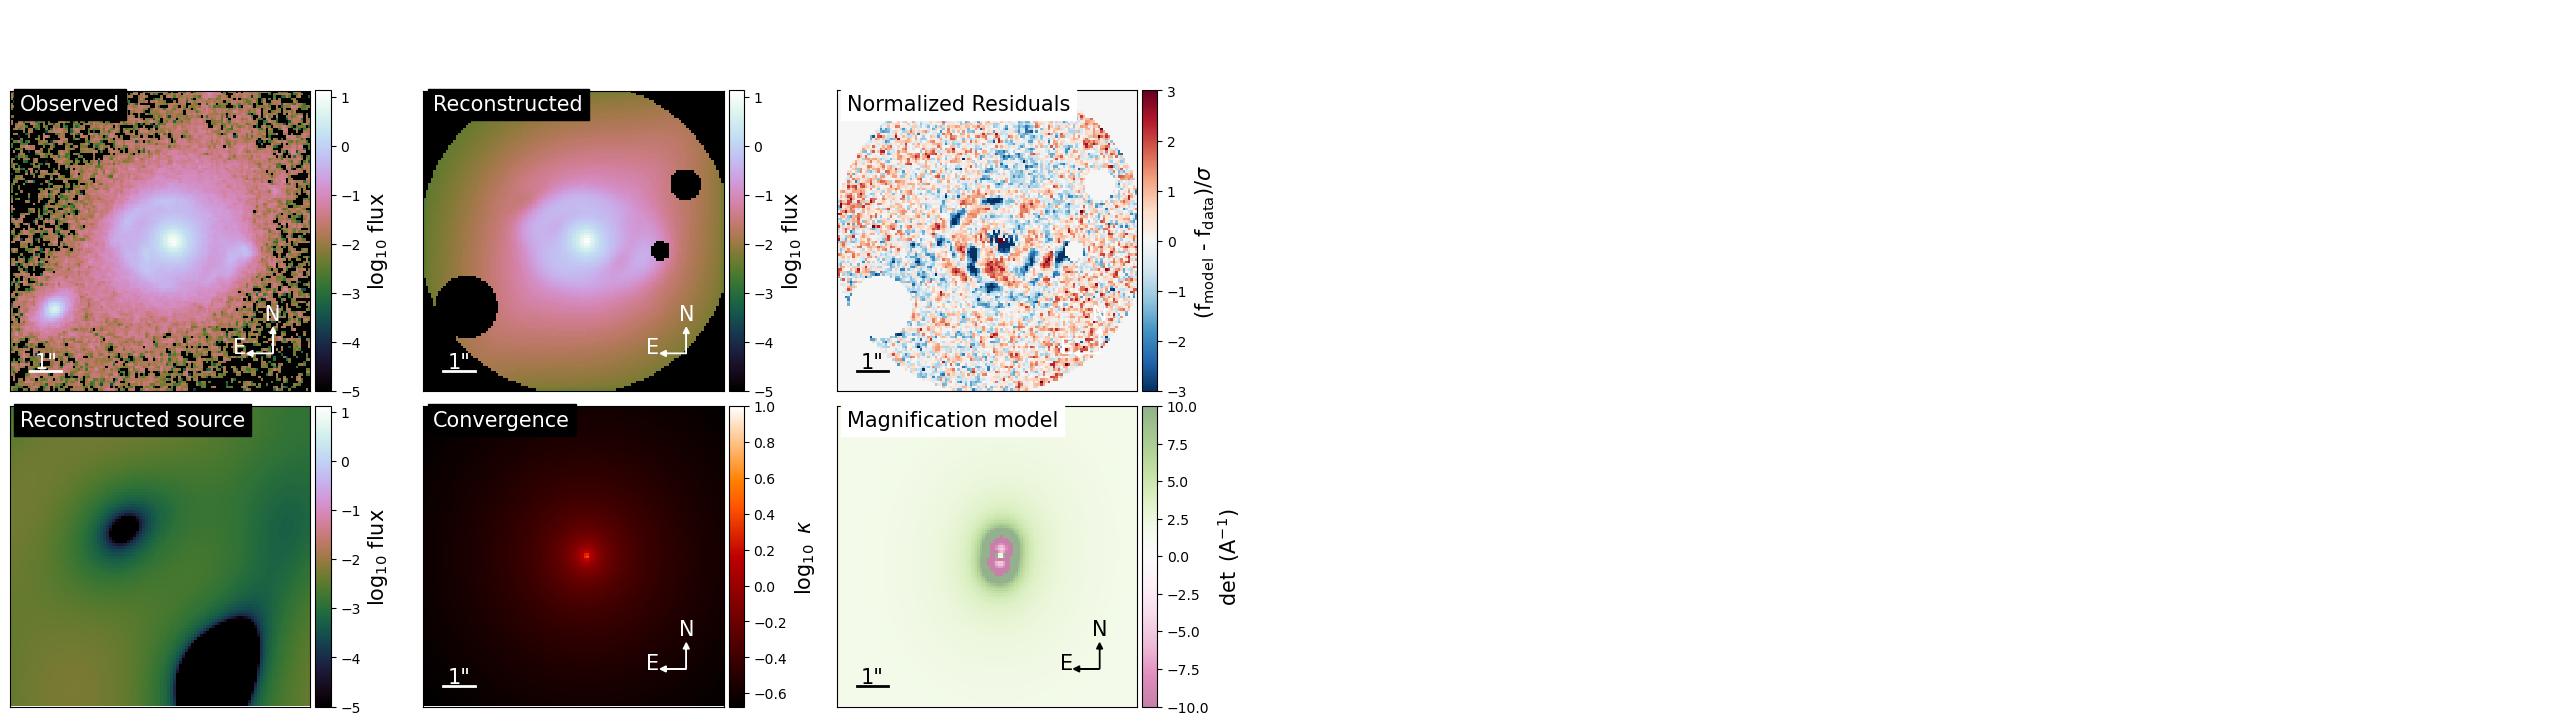

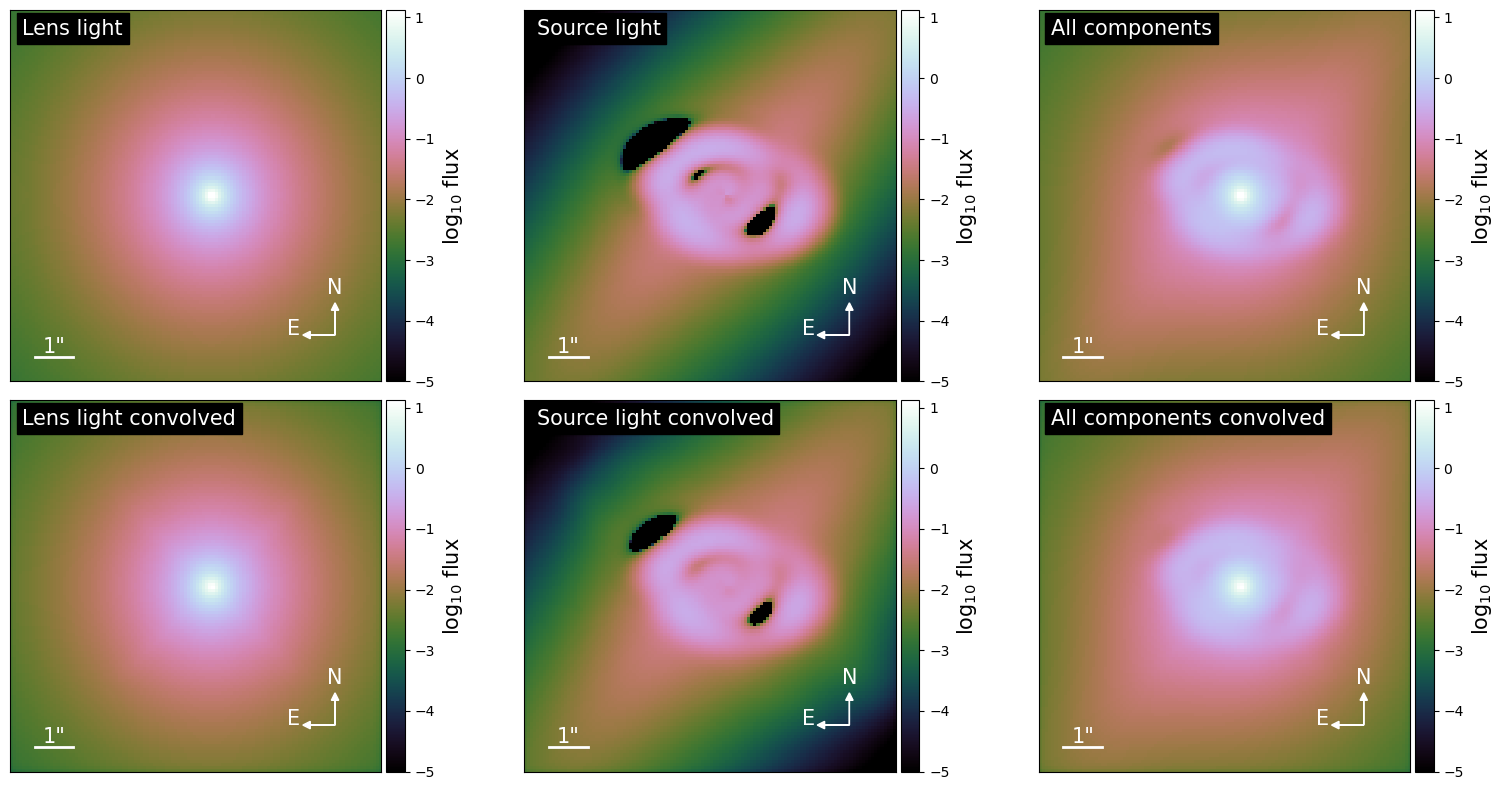

In [167]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()